In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy

from pycuda.compiler import SourceModule
import numpy as np
from pycuda.gpuarray import vec
from pycuda import gpuarray
import pandas as pd

In [6]:
source_code = r"""
#include <stdio.h>

__global__ void fold_fft_blocks(const float2 *pol0, const float2 *pol1, 
        const double *phase, const double *step, 
        const int fftlen, const int overlap, const int nbin, const int num_fft,
        float2 *xx, float2 *yy, float2 *xy, unsigned *hits) {

    // Size params
    const int ibina = threadIdx.x;
    const int nbina = blockDim.x;
    const int ibinb = blockIdx.x;
    const int ibin = ibinb*nbina + ibina;
    const int ichan = blockIdx.y;
    const int nvalid = fftlen - overlap;
    
    float2 foldxxlag = make_float2(0,0);
    float2 foldyylag = make_float2(0,0);
    float2 foldxylag = make_float2(0,0);
    int foldcount = 0;


    for (int ifft=0; ifft < num_fft; ifft++){
        const float2 *ptr0 = pol0 +ichan*fftlen*num_fft + ifft*fftlen + overlap/2;
        const float2 *ptr1 = pol1 + ichan*fftlen*num_fft + ifft*fftlen + overlap/2;
        // Fold info
        const double bin0 = phase[ifft];
        const double bin_samp = step[ifft];   // bins/sample
        const double samp_bin = 1.0/bin_samp; // samples/bin
        const int nturn = ((double)nvalid*bin_samp)/(double)nbin + 2;

        // Loop over number of pulse periods in data block
        for (int iturn=0; iturn<nturn; iturn++) {
        
            // Determine range of samples needed for this bin, turn
            int samp0 = samp_bin*((double)ibin-bin0+(double)iturn*nbin)+0.5;
            int samp1 = samp_bin*((double)ibin-bin0+(double)iturn*nbin+1)+0.5;

            // Range checks
            if (samp0<0) { samp0=0; }
            if (samp1<0) { samp1=0; }
            if (samp0>nvalid) { samp0=nvalid; }
            if (samp1>nvalid) { samp1=nvalid; }

            // Read in and add samples
            int idx;
            for (int isamp=samp0; isamp<samp1; isamp++) {
                float2 p0 = ptr0[isamp];
                float2 p1 = ptr1[isamp];
                foldxxlag.x += p0.x*p0.x + p0.y*p0.y;

                foldyylag.x += p1.x*p1.x + p1.y*p1.y;

                foldxylag.x += p0.x*p1.x + p0.y*p1.y;
                foldxylag.y += p0.x*p1.y - p0.y*p1.x;
                foldcount++;
            }
        }
        
    }
    xx[ichan*nbin+ibin] = foldxxlag;
    yy[ichan*nbin+ibin] = foldyylag;
    xy[ichan*nbin+ibin] = foldxylag;
    hits[ichan*nbin+ibin] = foldcount;
}
"""

In [4]:


start = cuda.Event()
end = cuda.Event()
#print dest-a*b

In [84]:
start_free = cuda.mem_get_info()[0]
results = []
for max_registers in [32,64]:
    mod = SourceModule(source_code,options=['--maxrregcount=%d' % max_registers])
    fold_fft_blocks = mod.get_function("fold_fft_blocks")
    for num_channels in [8,16,64]:
        for num_bins in [128,512,2048]:
            for num_lags in [1]:#,1024,2048]:
                for samples_per_bin in [1.08,16,30,256]:
                    for fft_len in [2**15,2**16,2**17]:
                        for overlap in [128,512,2048]:

                            num_bytes=2**27
                            num_pols=2
                            bytes_per_sample = 8 #complex64 (two 32 bit floats)
                            num_samples = num_bytes//(bytes_per_sample*num_pols*num_channels)
                            num_fft = num_samples//fft_len
                            if num_fft == 0:
                                continue
                            x = (np.arange(1,num_pols+1)[:,None,None,None]+np.arange(num_channels)[None,:,None,None]*10 
                                 + np.arange(num_fft)[None,None,:,None]*1000 + (np.arange(-overlap//2,fft_len-overlap//2)*1j)[None,None,None,:]).astype('complex64')
                            x[:,:,:,:overlap//2] = np.nan+1j*np.nan
                            x[:,:,:,-overlap//2:] = np.nan+1j*np.nan

                            pol0 = gpuarray.to_gpu(x[0].view(vec.float2).ravel())
                            pol1 = gpuarray.to_gpu(x[1].view(vec.float2).ravel())
                            num_valid = fft_len-overlap
                            phase = np.mod(np.arange(num_fft,dtype='float64')*(num_valid)/(samples_per_bin),num_bins)
                            step = (1./samples_per_bin)*np.ones((num_fft,),dtype='float64')
                            phase_gpu = gpuarray.to_gpu(phase)
                            step_gpu = gpuarray.to_gpu(step)

                            bins_per_fft = (fft_len-overlap)/samples_per_bin
                            xx = np.zeros((num_channels,num_bins),dtype='complex64')
                            yy = np.zeros((num_channels,num_bins),dtype='complex64')
                            xy = np.zeros((num_channels,num_bins),dtype='complex64')
                            hits = np.zeros((num_channels,num_bins),dtype=np.uint32)
                            xx2 = gpuarray.to_gpu(xx.view(vec.float2))
                            yy2 = gpuarray.to_gpu(yy.view(vec.float2))
                            xy2 = gpuarray.to_gpu(xy.view(vec.float2))
                            hits_gpu = gpuarray.to_gpu(hits)

                            start.synchronize()

                            start.record()
                            fold_fft_blocks(pol0,pol1,phase_gpu,step_gpu,
                                            np.int32(fft_len), np.int32(overlap), 
                                            np.int32(num_bins), np.int32(num_fft),
                                            xx2, yy2, xy2, hits_gpu,
                                    block=(min((num_bins, 1024)),1,1), grid=(max((1,num_bins//1024)),num_channels))
                            end.record()
                            end.synchronize()
                            elapsed = start.time_till(end)
                            mem_used = start_free-cuda.mem_get_info()[0]
                            #print mem_used/1e6

                            del pol0, pol1, xx2, yy2, xy2, hits_gpu,phase_gpu,step_gpu

                            results.append(dict(elapsed=elapsed,num_lags=num_lags,num_bins=num_bins,
                                                num_fft=num_fft,fft_len=fft_len, overlap=overlap,
                                               samples_per_bin=samples_per_bin,num_channels=num_channels,
                                                mem_used=mem_used,max_registers=max_registers,
                                               num_registers=fold_fft_blocks.num_regs))

results = pd.DataFrame(results)

#print "approx num bins", (num_valid*num_fft/float(samples_per_bin))
#print "approx num turns",(num_valid*num_fft/float(samples_per_bin)/float(num_bins))
#print "approx hits per bin", (num_valid*num_fft)/float(num_bins)h

/home/gjones/miniconda2/envs/crab/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(47): warning: variable "idx" was declared but never referenced

kernel.cu(47): warning: variable "idx" was declared but never referenced

ptxas warning : Too big maxrregcount value specified 64, will be ignored



In [85]:
results.shape

(648, 11)

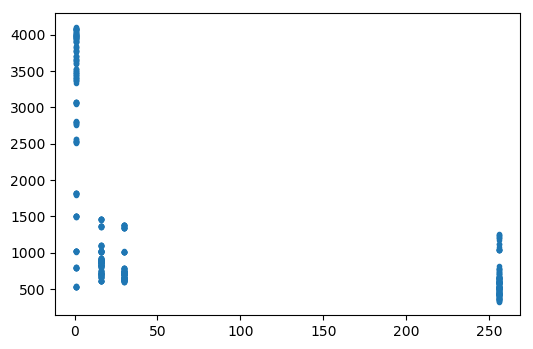

In [73]:
plot(results.samples_per_bin,1e-6*(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

In [34]:
#results.to_hdf('2017-06-07-multichannel-results.h5','results')

In [35]:
#r2 = pd.read_hdf('2017-06-07-multichannel-results.h5',key='results')

In [60]:
2**27/8/2/64/4

32768

In [86]:
results['ns_per_sample']=(1e6*results.elapsed/(results.num_channels*results.num_fft*results.fft_len))

In [98]:
ng = results[(results.num_channels==64) & (results.num_bins==2048) & (results.max_registers==64)]

In [96]:
def add_guppi_lines(bandwidth=False,ax=None):
    if ax is None:
        ax = plt.gca()
    fold_value = (0.036+0.720+0.026)
    total_value = 3.4
    if bandwidth:
        fold_value = 1e9/fold_value
        total_value = 1e9/total_value
    ax.axhline(fold_value,linestyle='--')
    ax.text(1,fold_value*.9,('GUPPI folding'),va='top')
    ax.axhline(total_value,linestyle=':',color='gray')
    ax.text(1,total_value*.95,('GUPPI total'),va='top',color='gray')
    
    

In [108]:
import seaborn as sns
sns.set_context('notebook')
sns.set(font_scale=1.5)

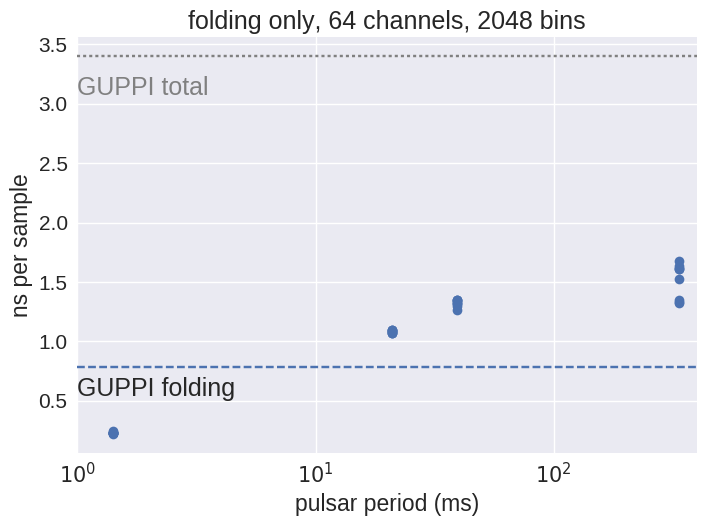

In [111]:
#for k,group in ng.groupby(ng.overlap):

group = ng
semilogx(1e3*group.samples_per_bin*group.num_bins/(800e6/512.),group.ns_per_sample,'o',label=('%d registers' % k))
#axhline((0.036+0.720+0.026))
#axhline(3.4,linestyle=':',color='gray')
add_guppi_lines()
#legend(loc='upper right')
xlabel('pulsar period (ms)')
xlim(1,400)
ylabel('ns per sample')
title('folding only, 64 channels, 2048 bins')
#grid()

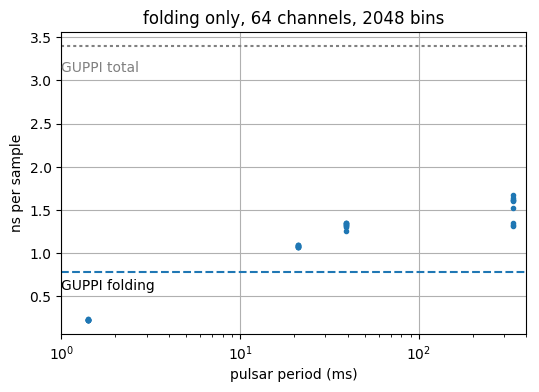

In [103]:
#for k,group in ng.groupby(ng.overlap):
group = ng
semilogx(1e3*group.samples_per_bin*group.num_bins/(800e6/512.),group.ns_per_sample,'.',label=('%d registers' % k))
#axhline((0.036+0.720+0.026))
#axhline(3.4,linestyle=':',color='gray')
add_guppi_lines()
#legend(loc='upper right')
xlabel('pulsar period (ms)')
xlim(1,400)
ylabel('ns per sample')
title('folding only, 64 channels, 2048 bins')
grid()

In [58]:
k

32768

In [30]:
4*(2**15-512)

129024

In [29]:
2**27/(2*8*2**15*64)

4

In [25]:
x=np.fft.rfft(np.random.randn(16))
x[-1] =0
np.fft.irfft(x)

array([-1.33550323, -1.00248744,  1.25192525, -0.31767118, -0.79804778,
        0.75065255,  0.49108101, -0.10363547, -0.74672904, -0.19105449,
       -0.64053487, -0.6365607 , -0.3748567 ,  0.49806207,  0.63239626,
       -0.51757445])

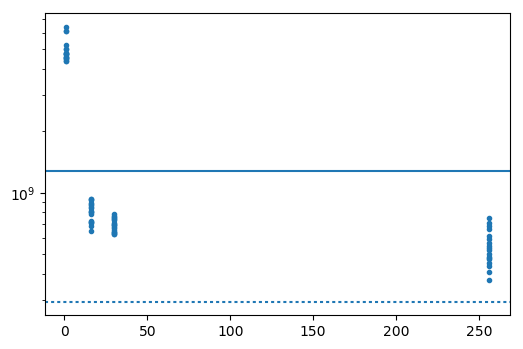

In [41]:
semilogy(ng.samples_per_bin,1e9/ng.ns_per_sample,'.')
axhline(1e9/(0.036+0.720+0.026))
axhline(1e9/(3.4),linestyle=':')


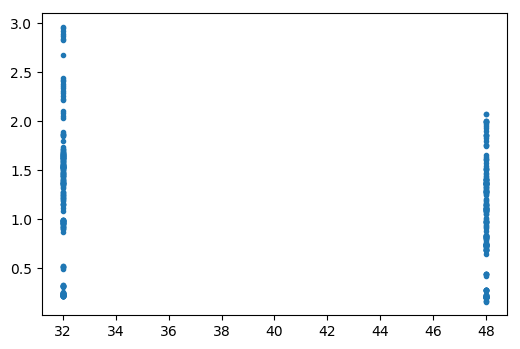

In [43]:
plot(results.max_registers,results.ns_per_sample,'.')

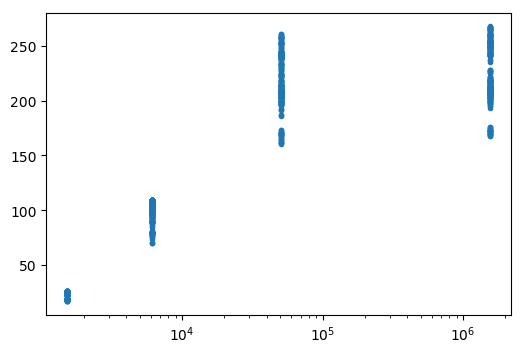

In [8]:
semilogx((800e6/512)/(2*(results.num_lags-1)+1),1e-6*(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

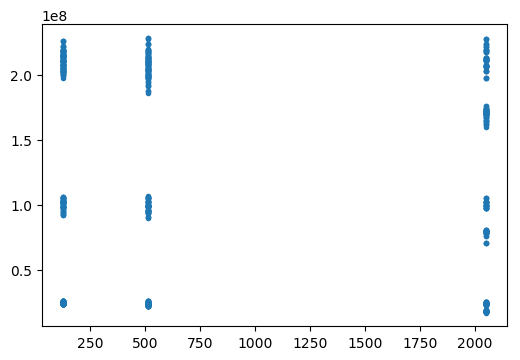

In [36]:
plot(results.num_bins,(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

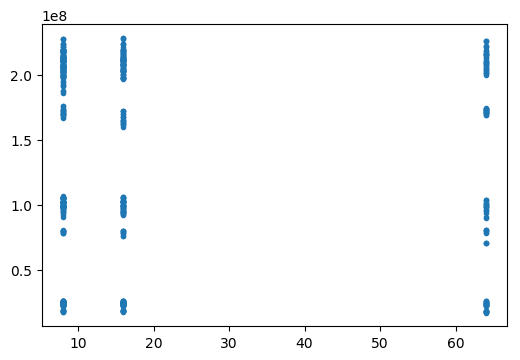

In [37]:
plot(results.num_channels,(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

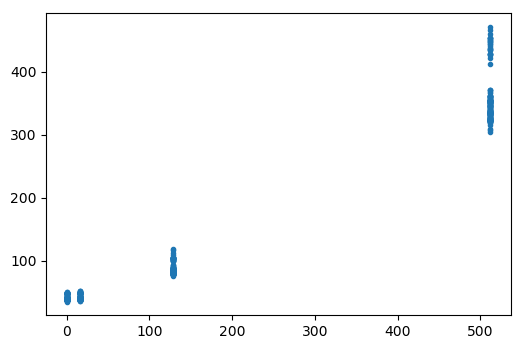

In [38]:
plot(results.num_lags,results.elapsed,'.')

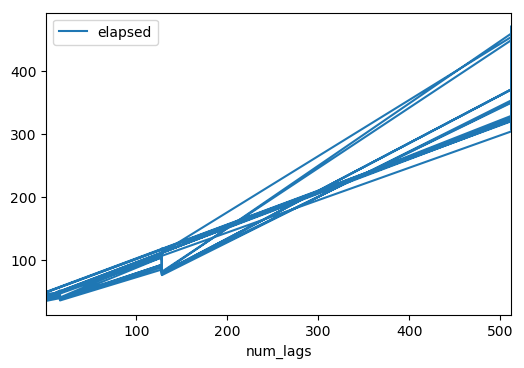

In [39]:
results.plot('num_lags','elapsed')

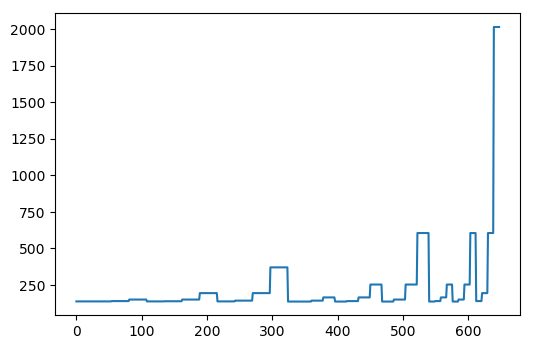

In [40]:
plot(results.mem_used/1e6)